# Your first CNN on CIFAR-10

In this task you will: 
* define your first CNN architecture for CIFAR-10 dataset
* train it from scratch
* visualize learnt filters

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="images/cifar10.jpg" style="width:80%">

# Import stuff

In [8]:
import sys
sys.path.append("..")
import grading
import download_utils

In [9]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!

In [10]:
download_utils.link_all_keras_resources()

In [11]:
import tensorflow as tf
import keras
import keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import grading_utils
import keras_utils
from keras_utils import reset_tf_session


s = keras_utils.reset_tf_session()


from tensorflow.python.client import device_lib
device_lib.list_local_devices()


1.12.0
2.1.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15474414674560606265, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5008041574
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9983532127837607656
 physical_device_desc: "device: 0, name: GeForce GTX 970M, pci bus id: 0000:01:00.0, compute capability: 5.2"]

# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [12]:
grader = grading.Grader(assignment_key="s1B1I5DuEeeyLAqI7dCYkg", 
                        all_parts=["7W4tu", "nQOsg", "96eco"])

In [13]:
# token expires every 30 min
COURSERA_TOKEN = "3XDN7t06ghn8n51M"
COURSERA_EMAIL = "mantarayk17@gmail.com"

# Load dataset

In [14]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [15]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [16]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


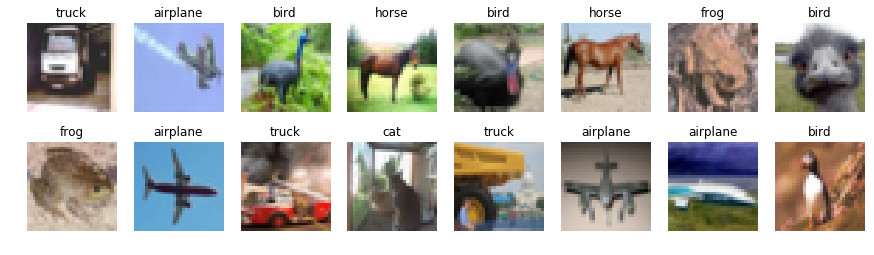

In [17]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [18]:
# normalize inputs
x_train2 = (x_train / 255) - 0.5
x_test2 = (x_test / 255) - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)
print(x_train2[0])
print(x_test2[0])
print(y_train2[0])
print(y_test2[0])

[[[-0.26862745 -0.25686275 -0.25294118]
  [-0.33137255 -0.31960784 -0.32352941]
  [-0.30392157 -0.31176471 -0.33137255]
  ...
  [ 0.11960784  0.01764706 -0.07647059]
  [ 0.09607843 -0.00980392 -0.1       ]
  [ 0.08039216 -0.01372549 -0.09607843]]

 [[-0.4372549  -0.42156863 -0.42156863]
  [-0.5        -0.5        -0.5       ]
  [-0.42941176 -0.46862745 -0.5       ]
  ...
  [-0.01764706 -0.15490196 -0.28431373]
  [-0.03333333 -0.1745098  -0.30392157]
  [-0.02156863 -0.15882353 -0.27647059]]

 [[-0.40196078 -0.40588235 -0.41764706]
  [-0.4372549  -0.47254902 -0.5       ]
  [-0.30784314 -0.39411765 -0.46862745]
  ...
  [-0.0372549  -0.17058824 -0.30392157]
  [-0.02941176 -0.17058824 -0.30392157]
  [-0.07254902 -0.21372549 -0.33529412]]

 ...

 [[ 0.31568627  0.16666667 -0.12352941]
  [ 0.28823529  0.1        -0.36666667]
  [ 0.27647059  0.13137255 -0.39803922]
  ...
  [ 0.12745098  0.02156863 -0.2254902 ]
  [-0.28039216 -0.37843137 -0.47254902]
  [-0.29215686 -0.36666667 -0.42156863]]

 [

# Define CNN architecture

In [19]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```

Stack __4__ convolutional layers with kernel size __(3, 3)__ with growing number of filters __(16, 32, 32, 64)__, use "same" padding.

Add __2x2__ pooling layer after every 2 convolutional layers (conv-conv-pool scheme).

Use __LeakyReLU__ activation with recommended parameter __0.1__ for all layers that need it (after convolutional and dense layers):
```python
model.add(LeakyReLU(0.1))
```

Add a dense layer with __256__ neurons and a second dense layer with __10__ neurons for classes. Remember to use __Flatten__ layer before first dense layer to reshape input volume into a flat vector!

Add __Dropout__ after every pooling layer (__0.25__) and between dense layers (__0.5__).

In [20]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    ### YOUR CODE HERE
    
    model.add(Conv2D(16, (3,3), input_shape=(32,32,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
        
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (3,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
        
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation("softmax"))
    
    return model

In [21]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [22]:
## GRADED PART, DO NOT CHANGE!
# Number of model parameters
grader.set_answer("7W4tu", grading_utils.model_total_params(model))

In [23]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


# Train model

Training of your model can take approx. 4-8 minutes per epoch.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [24]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = reset_tf_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

Training takes approximately **1.5 hours**. You're aiming for ~0.80 validation accuracy.

In [25]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
#from keras.models import load_model
#s = reset_tf_session()
#last_finished_epoch = 7
#model = load_model(model_filename.format(last_finished_epoch))

In [26]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               keras_utils.TqdmProgressCallback(),
               keras_utils.ModelSaveCallback(model_filename)],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=2,
    initial_epoch=last_finished_epoch or 0
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Learning rate: 0.005

Epoch 1/10


 - 34s - loss: 1.3559 - acc: 0.5171 - val_loss: 0.9755 - val_acc: 0.6521

Model saved in cifar.000.hdf5
Epoch 2/10
Learning rate: 0.0045

Epoch 2/10


 - 27s - loss: 0.9509 - acc: 0.6653 - val_loss: 0.8370 - val_acc: 0.7085

Model saved in cifar.001.hdf5
Epoch 3/10
Learning rate: 0.00405

Epoch 3/10


 - 27s - loss: 0.8181 - acc: 0.7126 - val_loss: 0.7549 - val_acc: 0.7383

Model saved in cifar.002.hdf5
Epoch 4/10
Learning rate: 0.003645

Epoch 4/10


 - 27s - loss: 0.7332 - acc: 0.7426 - val_loss: 0.6801 - val_acc: 0.7620

Model saved in cifar.003.hdf5
Epoch 5/10
Learning rate: 0.0032805

Epoch 5/10


 - 27s - loss: 0.6659 - acc: 0.7670 - val_loss: 0.6941 - val_acc: 0.7586

Model saved in cifar.004.hdf5
Epoch 6/10
Learning rate: 0.00295245

Epoch 6/10


 - 27s - loss: 0.6208 - acc: 0.7824 - val_loss: 0.6517 - val_acc: 0.7750

Model saved in cifar.005.hdf5
Epoch 7/10
Learning rate: 0.002657205

Epoch 7/10


 - 26s - loss: 0.5807 - acc: 0.7962 - val_loss: 0.6326 - val_acc: 0.7828

Model saved in cifar.006.hdf5
Epoch 8/10
Learning rate: 0.0023914846

Epoch 8/10


 - 26s - loss: 0.5419 - acc: 0.8075 - val_loss: 0.6482 - val_acc: 0.7863

Model saved in cifar.007.hdf5
Epoch 9/10
Learning rate: 0.002152336

Epoch 9/10


 - 27s - loss: 0.5135 - acc: 0.8202 - val_loss: 0.6244 - val_acc: 0.7891

Model saved in cifar.008.hdf5
Epoch 10/10
Learning rate: 0.0019371024

Epoch 10/10


 - 27s - loss: 0.4861 - acc: 0.8291 - val_loss: 0.5947 - val_acc: 0.7971

Model saved in cifar.009.hdf5


In [27]:
# save weights to file
model.save_weights("weights.h5")

In [28]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# Evaluate model

In [29]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

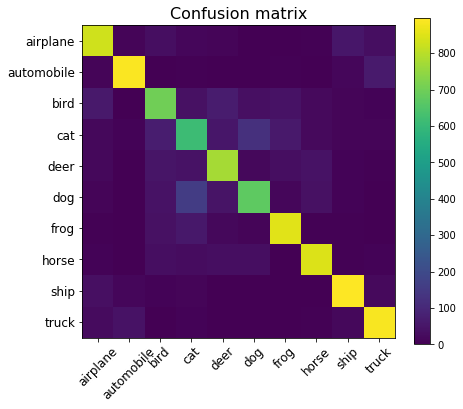

Test accuracy: 0.7971


In [30]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

In [31]:
## GRADED PART, DO NOT CHANGE!
# Accuracy on validation data
grader.set_answer("nQOsg", accuracy_score(y_test, y_pred_test_classes))

In [32]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


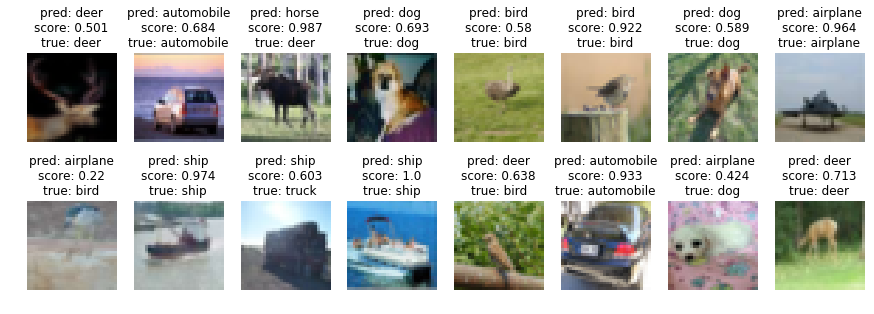

In [33]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Visualize maximum stimuli

We want to find input images that provide maximum activations for particular layers of our network. 

We will find those maximum stimuli via gradient ascent in image space.

For that task we load our model weights, calculate the layer output gradient with respect to image input and shift input image in that direction.

In [34]:
s = reset_tf_session()  # clear default graph
K.set_learning_phase(0)  # disable dropout
model = make_model()
model.load_weights("weights.h5")  # that were saved after model.fit

In [35]:
# all weights we have
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [36]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x = (x - np.mean(x)) * (0.25/np.std(x))

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x + 0.5) * 255
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [37]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

leaky_re_lu_1


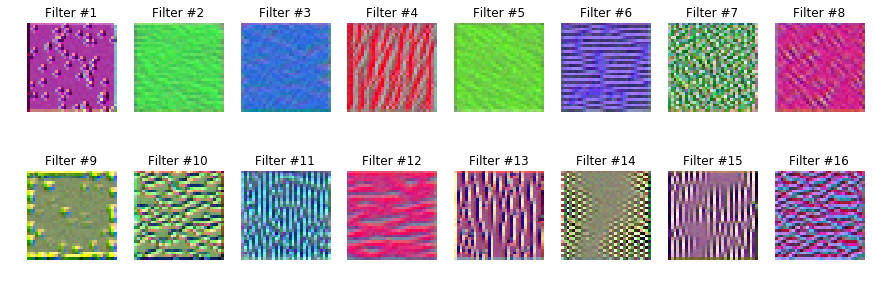

leaky_re_lu_2


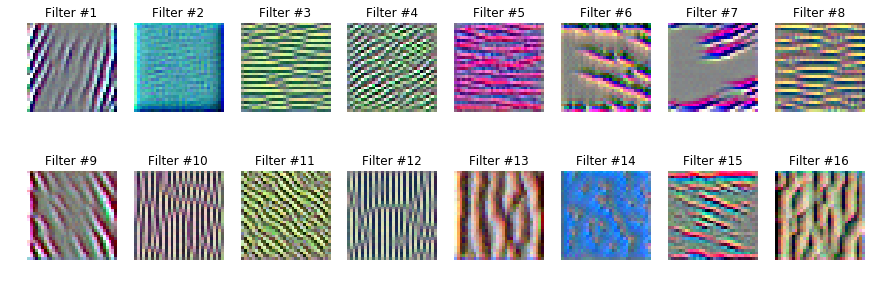

leaky_re_lu_3


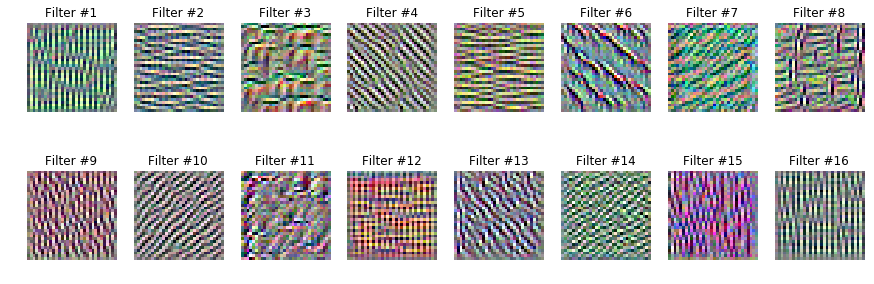

leaky_re_lu_4


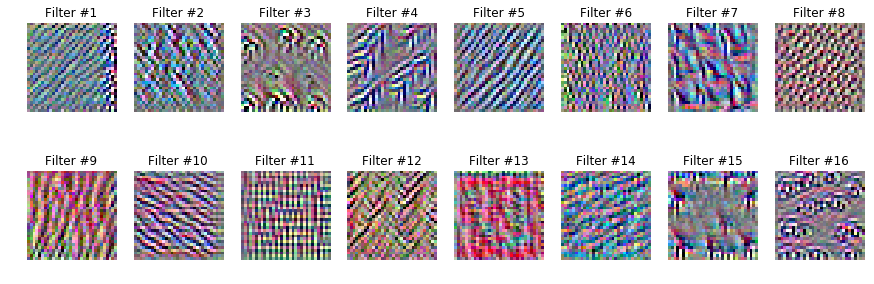

In [38]:
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for l in range(0, len(model.layers)):
    if isinstance(model.layers[l], LeakyReLU) and isinstance(model.layers[l-1], Conv2D):
        conv_activation_layers.append(model.layers[l])

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

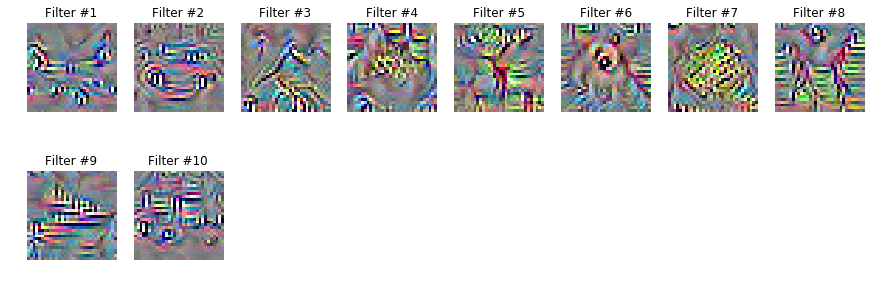

In [39]:
# maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)

In [40]:
def maximum_stimuli_test_for_grader():
    layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
    output_index = 7
    stimuli, loss = find_maximum_stimuli(
        layer_name=layer.name, 
        is_conv=False, 
        filter_index=output_index,
        model=model,
        verbose=True
    )
    return model.predict_proba(stimuli[np.newaxis, :])[0, output_index]

In [41]:
## GRADED PART, DO NOT CHANGE!
# Maximum stimuli test
grader.set_answer("96eco", maximum_stimuli_test_for_grader())

Current loss value: -6.6022944
Current loss value: -1.9793246
Current loss value: 0.15110864
Current loss value: 4.1794453
Current loss value: 10.563682
Current loss value: 18.695677
Current loss value: 25.111322
Current loss value: 31.543203
Current loss value: 38.41875
Current loss value: 43.158524
Current loss value: 50.698757
Current loss value: 56.13812
Current loss value: 63.777496
Current loss value: 69.01777
Current loss value: 76.492386
Current loss value: 82.58952
Current loss value: 89.761955
Current loss value: 95.86116
Current loss value: 102.17485
Current loss value: 107.60459


In [40]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


That's it! Congratulations!

What you've done:
- defined CNN architecture
- trained your model
- evaluated your model
- visualised learnt filters